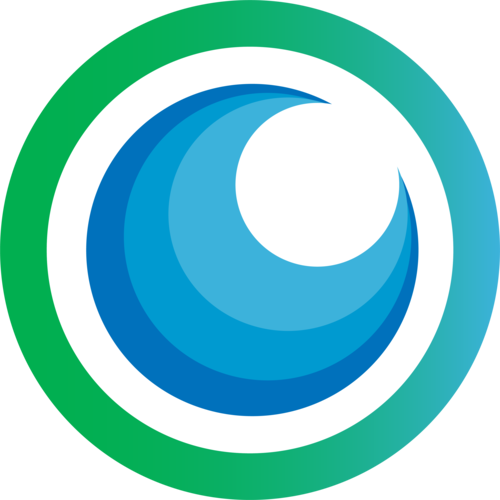
# Epoch Tutorials: High Performance

### Introduction
This notebook is part of the Epoch III onboarding for the engineers departement, and can be used as reference for future competitions on the topic of high performance image classification and transfer learning.

### Data
The dataset used in this notebook is a small subset of the data Epoch used in the Deep Chimpact competition. The data is stored as seperate npy files, where the last float number in the file name is the regression label of the image, which represents how far from the camera the wildlife in the frame. In total, there are 1228 images. In "big data" competitions like this (the original data Epoch trained on was about 100 times as large), it is impossible to fit all data in RAM and train models like we did in previous tutorials. <b> Therefore, in the transfer learning part of this notebook, we will assume we can only fit 1 batch of 32 images in RAM at the same time.</b>


### Contents
- [Explorative Data Analysis (EDA)](#Explorative-Data-Analysis-(EDA))
- [Transfer Learning](#Transfer-Learning)
- [Handling Large Data](#Handling-Large-Data)
- [Putting it Together](#Putting-it-Together)


In [11]:
# Imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import os

from classification_models.tfkeras import Classifiers

np.random.seed(0)

# Data paths
train_data_path = "../data/chimp_data_train/"
test_data_path = "../data/chimp_data_test/"

### Explorative Data Analysis (EDA)

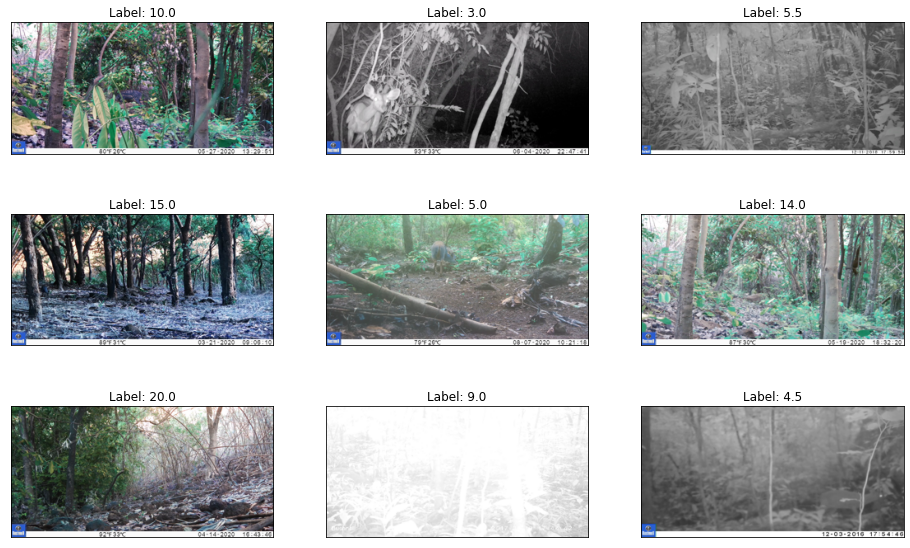

In [12]:
# Let's look at some of the images
fig, axs = plt.subplots(3, 3, figsize=(16, 10))
for i in range(9):
    path = train_data_path + os.listdir(train_data_path)[np.random.randint(0, len(os.listdir(train_data_path)))]
    image = np.load(path)
    axs[i//3, i%3].imshow(image)
    axs[i//3, i%3].set_title(f"Label: {path.split('_')[-1][:-4]}")
    axs[i//3, i%3].get_xaxis().set_visible(False)
    axs[i//3, i%3].get_yaxis().set_visible(False)

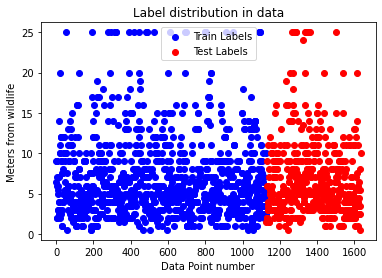

In [13]:
# Let's take a look at the label distribution
# For this, we need to parse the labels from the filenames

train_labels, test_labels = [], []

for path in os.listdir(train_data_path):
    train_labels.append(float(path.split('_')[-1][:-4]))

for path in os.listdir(test_data_path):
    test_labels.append(float(path.split('_')[-1][:-4]))

plt.scatter(range(len(train_labels)), train_labels, color="blue", label="Train Labels")
plt.scatter(range(len(train_labels), len(test_labels) + len(train_labels)), test_labels, color="red", label="Test Labels")

plt.xlabel("Data Point number")
plt.ylabel("Meters from wildlife")
plt.legend(loc='upper center')

plt.title("Label distribution in data")
plt.show()

### Transfer Learning

In [14]:
# We want to use a pretrained resnet34 (many other models available from the package we use)
# For our task, we take off the layers responsible for performing the task, but keep the deep convolutional layers
# These are trained on extracting features, which is very useful for our data

# Load the pretrained model
ResNet34, preprocess_input = Classifiers.get('resnet34')

# Get the Resnet model, provide input shape of our data and specify on what problem it should be pretrained
base_model = ResNet34(input_shape=(320, 640, 3), weights='imagenet', include_top=False)

# Construct our output layers at the end of the pretrained model
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# And specify multiplication with the previous layer instantly
flatten = tf.keras.layers.Dense(256, activation='relu')(x)

# Construct the actual output layer
# We will use a linear layer (which basically does nothing)
output = tf.keras.layers.Dense(1, activation='linear')(flatten)

# Construct the model from the pretrained (34) deep layers, and the specified output layers
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Compile the model
# We will use Stochastic Gradient Descent and MAE as loss, since this was the competition  evaluation metric
model.compile(optimizer="SGD", loss=tf.keras.losses.MeanAbsoluteError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

# You could print the model summary, but it will be very long ;)
# model.summary()

### Handling Large Data

As mentioned in the introduction, image classification tasks often include immense datasets. In the actual dataset where our data was sampled from, the raw image data provided was about 350 times larger than the one we use in this notebook, which is 200MB. Therefore, clearly we cannot store the entire data while we train on it, as we are used. Therefore, in this section we will define a Keras datagenerator.


In [15]:
# Create the datagenerator which inherits from the Sequence class in keras
class DataGenerator(tf.keras.utils.Sequence) :
    def __init__(self, dir_path, batch_size=32):
        """
        Few things to mention:
            - The data generator tells our model how to fetch one batch of training data (in this case from files)
            - Any work that can be done before training, should be done in init, since we want fetching a batch to be fast
            - Therefore, we want all filenames and labels to be determined before training
            - This saves work, because we will be fetching batches multiple times (across epochs)
        """
        # Get all filenames in directory
        self.filenames = [dir_path + file for file in os.listdir(dir_path)]
        
        # Get all labels from the filenames (splitting on _, last one, and remove the file extension .npy)
        self.labels = list(map(lambda l: float(l.split('_')[-1][:-4]), self.filenames))
        
        # Include batch size as attribute
        self.batch_size = batch_size

    def __len__(self) :
        """
        Should return the number of BATCHES the generator can retrieve (partial batch at end counts as well)
        """
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))


    def __getitem__(self, idx) :
        """
        Tells generator how to retrieve BATCH idx
        """
        # Get filenames for X batch
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Get labels for y batch
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Return X, y, where X is made of loaded np arrays from the filenames
        return np.array([np.load(filename) for filename in batch_x]), np.array(batch_y)

### Putting it Together

In [16]:
# Create the generator
train_generator = DataGenerator(train_data_path, batch_size=32)
test_generator = DataGenerator(test_data_path, batch_size=32)

# Train the model using the generator (so no explicit data is provided)
model.fit(train_generator, epochs=1, verbose=1)

# Test the model with the test generator
model.evaluate(test_generator)

Epoch 1/25
36/36 [==============================] - 284s 8s/step - loss: 3.4333 - mean_absolute_error: 3.4333
Epoch 2/25
36/36 [==============================] - 281s 8s/step - loss: 2.4850 - mean_absolute_error: 2.4850
Epoch 3/25
36/36 [==============================] - 280s 8s/step - loss: 2.3438 - mean_absolute_error: 2.3438
Epoch 4/25
36/36 [==============================] - 278s 8s/step - loss: 1.9370 - mean_absolute_error: 1.9370
Epoch 5/25
36/36 [==============================] - 282s 8s/step - loss: 1.8117 - mean_absolute_error: 1.8117
Epoch 6/25
36/36 [==============================] - 283s 8s/step - loss: 1.7269 - mean_absolute_error: 1.7269
Epoch 7/25
36/36 [==============================] - 280s 8s/step - loss: 1.6480 - mean_absolute_error: 1.6480
Epoch 8/25
36/36 [==============================] - 279s 8s/step - loss: 1.4527 - mean_absolute_error: 1.4527
Epoch 9/25
36/36 [==============================] - 280s 8s/step - loss: 1.4098 - mean_absolute_error: 1.4098
Epoch 10/2

[1.8419599533081055, 1.8419599533081055]

### Conclusion
This notebook provided an example of transfer learning on large image datasets, using pretrained models on the imagenet task. Many more models than the resnet34 are available. Actually, the best score retrieved by Epoch was reached by a resnet101 model (which is far larger). The final score reached by our model trained for 1 epoch is comparable with always predicting the mean. However, the task of predicting the distance to wildlife in large images is very complex, and needs much more data and more epochs of training. As becomes clear, these models are unfeasible to train on CPU only. 